In [2]:
import importlib
import numpy as np
import sklearn
from matplotlib import pyplot as plt
from os.path import join
import os
import seaborn as sns
from tqdm.notebook import tqdm as tqdm_notebook
import pickle
import glob
#### Custum libraries
import lib.algos_maxRSA as max_rsa
import lib.utils_RSA as rsa
import lib.utils_CKA as cka
from lib.algos import *


importlib.reload(rsa)
importlib.reload(cka)
importlib.reload(max_rsa)

<module 'lib.algos_maxRSA' from '/home/alban/projects/SAYCam_Vs_EGO4D/lib/algos_maxRSA.py'>

In [3]:
listpickles_ecoVal = glob.glob('/home/alban/Documents/results_image_selection/ecoVal_*.pkl')

RESULTS = {}
for p, pkl in enumerate(listpickles_ecoVal):
    name = pkl.split('/')[-1][:-4]
    f = open(pkl,"rb")
    RESULTS[name] = pickle.load(f)
    f.close()

In [4]:
list_names = [k for k in RESULTS.keys()]
similarities = {}

for n, name in enumerate(list_names):
    similarities[name] = [RESULTS[name]['similarity_dict'][pair]['similarity'] for pair in RESULTS[name]['similarity_dict'].keys()]

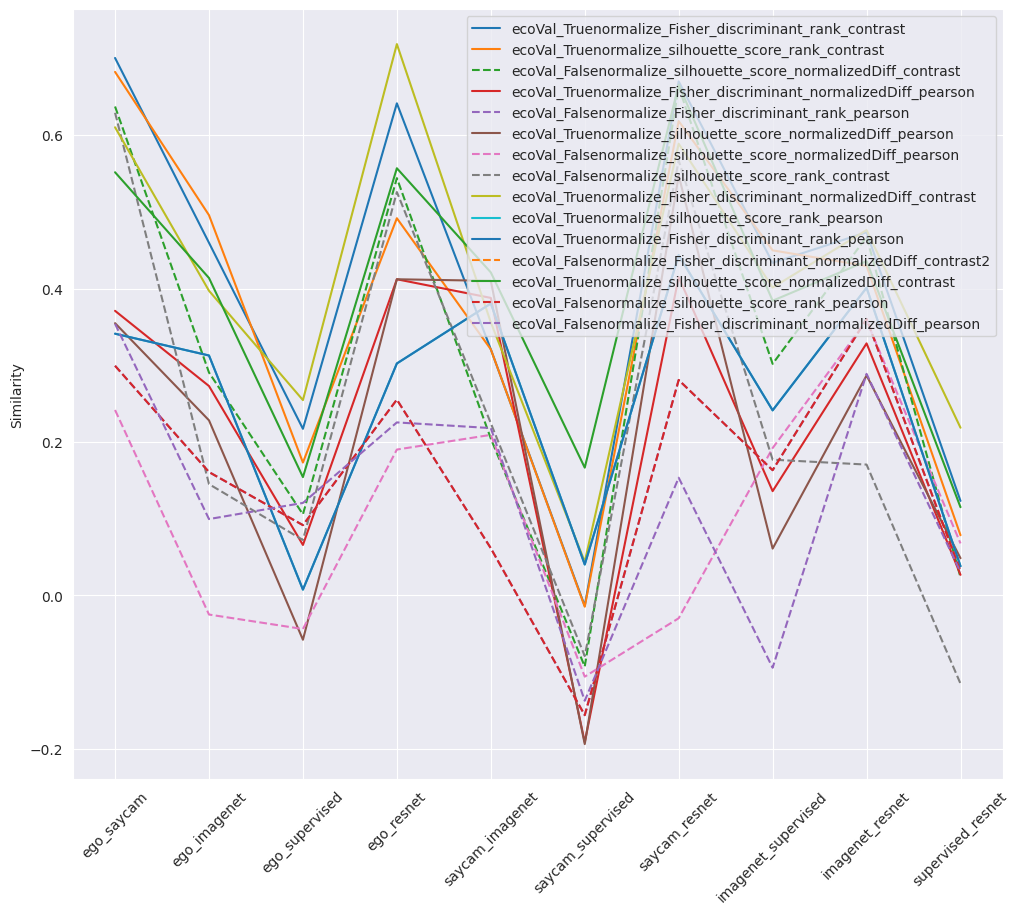

In [5]:
fig, ax = plt.subplots(figsize = (12,10))
for name in similarities.keys():
    if 'Falsenormalize' in name:
        plt.plot(similarities[name], label = name, ls = '--')
    else:
        plt.plot(similarities[name], label = name)
plt.ylabel('Similarity')
plt.xticks(list(range(10)), [pair for pair in RESULTS[name]['similarity_dict'].keys()], rotation = 45)
plt.legend(loc = 'upper right')
plt.show()

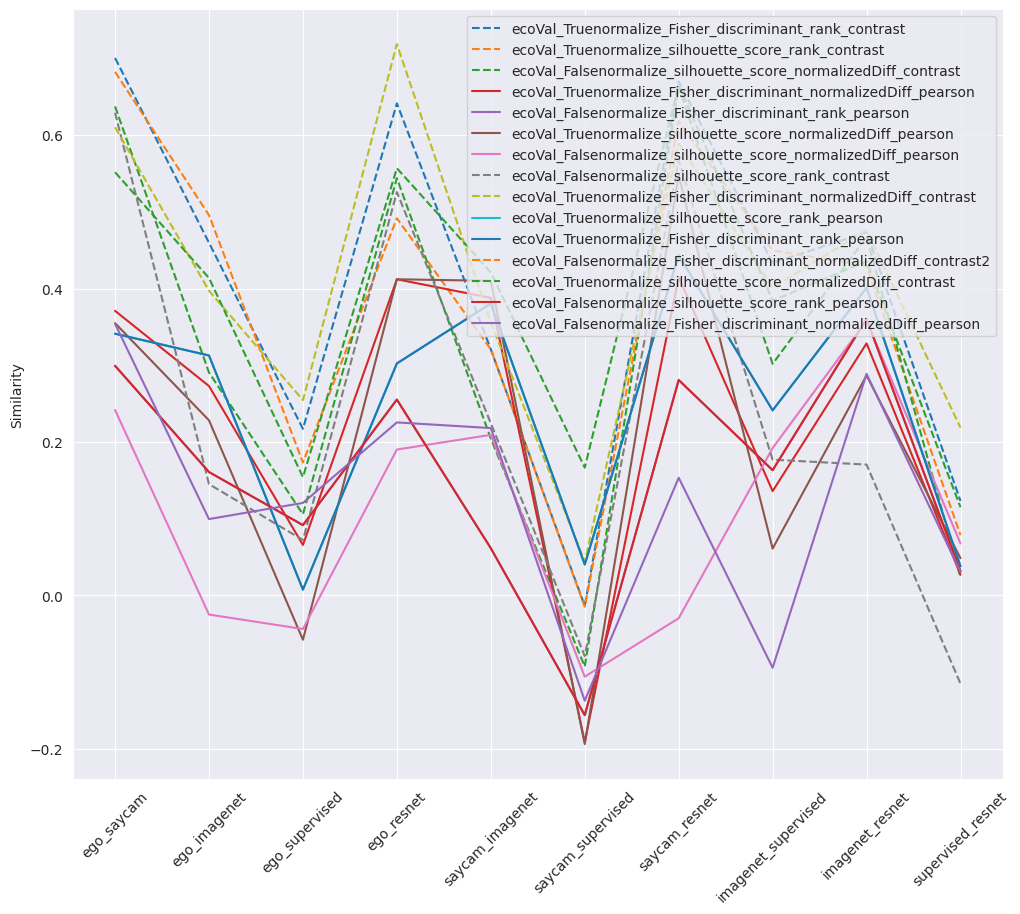

In [6]:
fig, ax = plt.subplots(figsize = (12,10))
for name in similarities.keys():
    if 'contrast' in name:
        plt.plot(similarities[name], label = name, ls = '--')
    else:
        plt.plot(similarities[name], label = name)
plt.ylabel('Similarity')
plt.xticks(list(range(10)), [pair for pair in RESULTS[name]['similarity_dict'].keys()], rotation = 45)
plt.legend(loc = 'upper right')
plt.show()

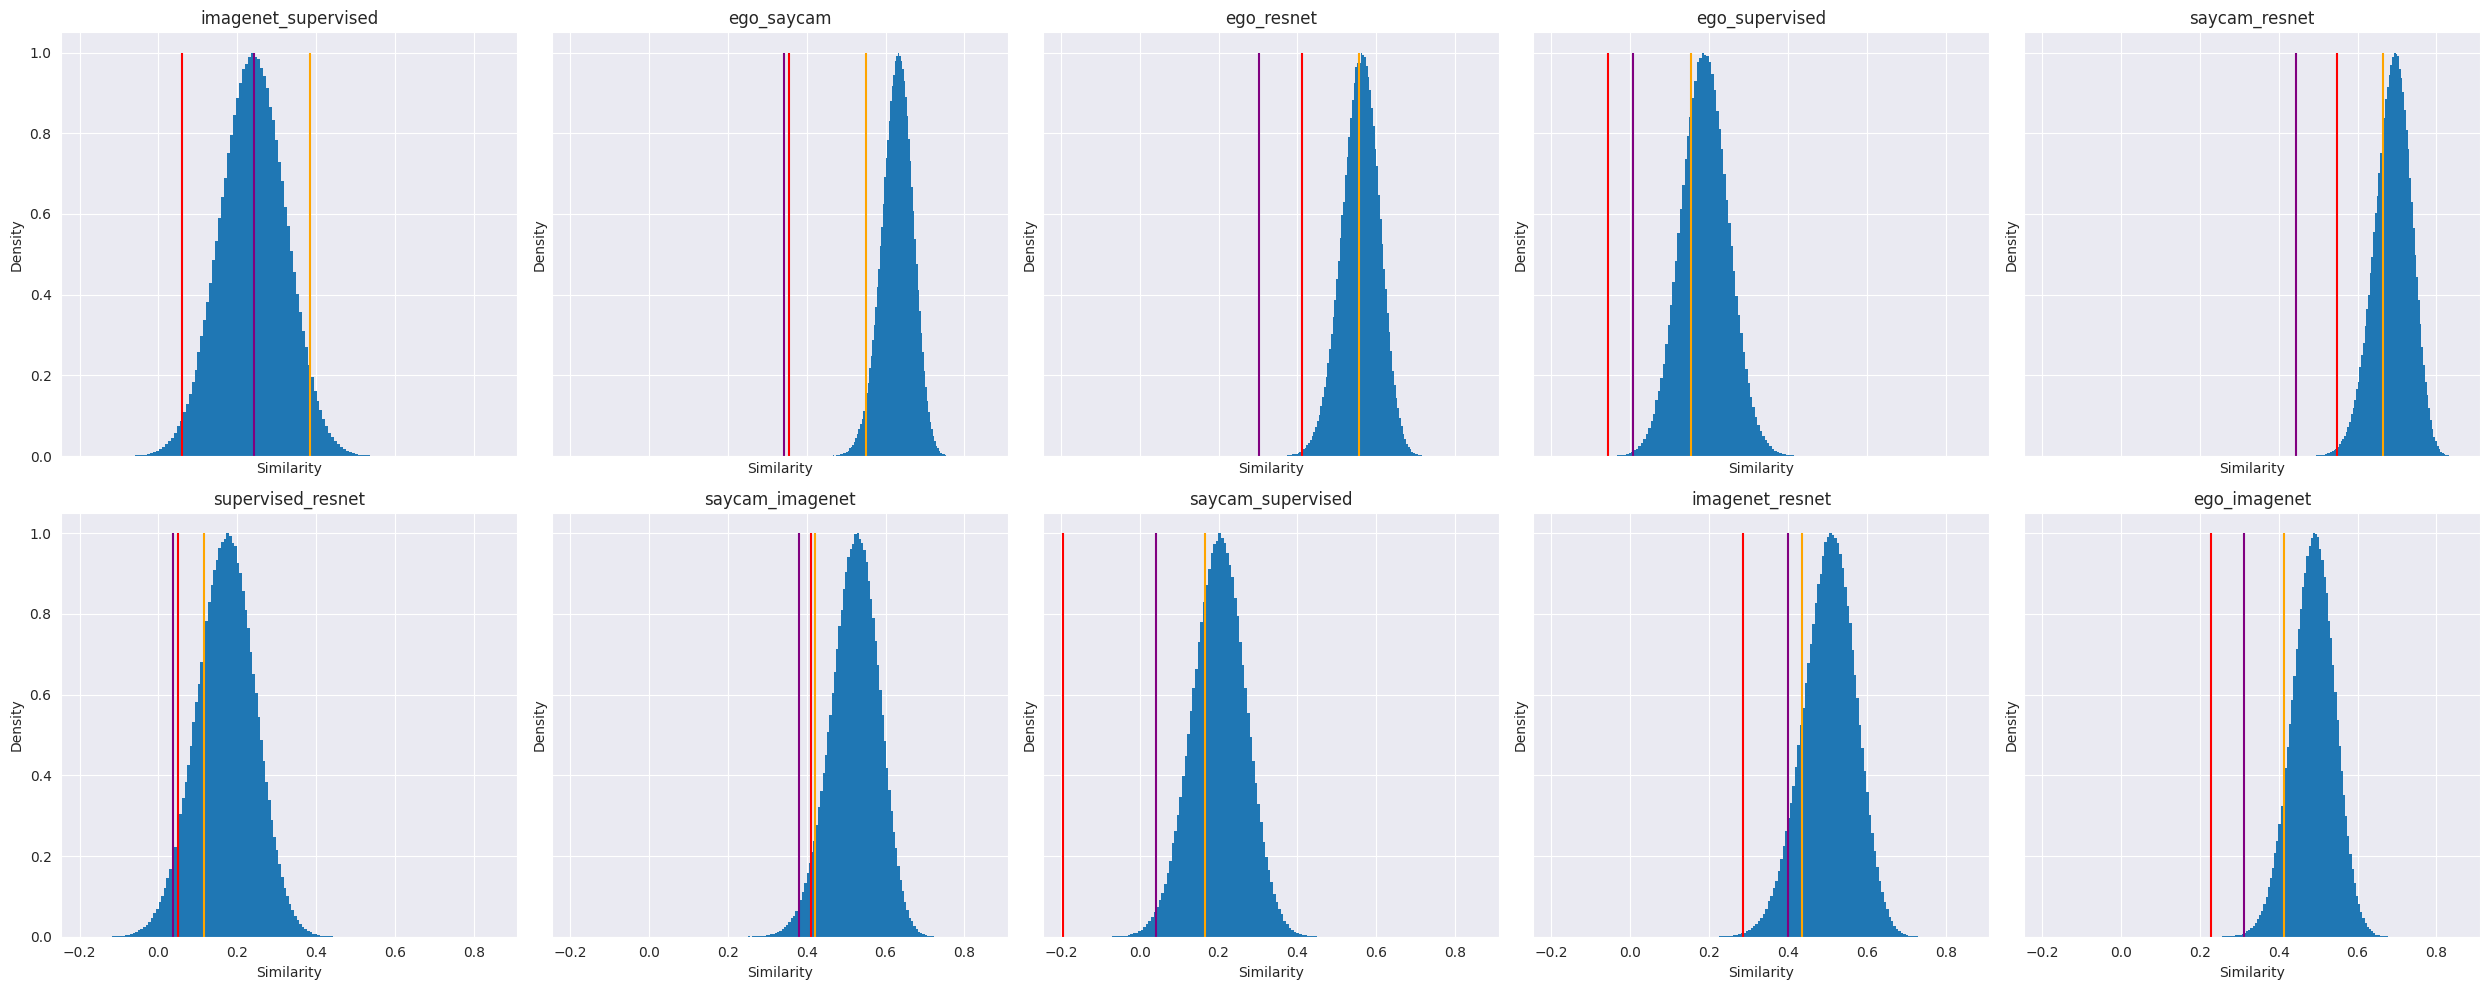

In [44]:
listsamples = glob.glob('results/*Truenormalize.npy')
nb_cols = 5
fig, subs = plt.subplots(nrows = 2, ncols = nb_cols, figsize = (25,10), sharex = True, sharey = True)
for f, file in enumerate(listsamples):
    sample = np.load(file)
    hist, bin_edges = np.histogram(sample, 100)
    subs[int(f/nb_cols), f%nb_cols].bar(bin_edges[:-1],hist/max(hist), width = bin_edges[1] - bin_edges[0], linewidth = 0, align = 'edge')
    #subs[f//5, f%5].legend()
    subs[int(f/nb_cols), f%nb_cols].set_xlabel('Similarity')
    subs[int(f/nb_cols), f%nb_cols].set_ylabel('Density')
    subs[int(f/nb_cols), f%nb_cols].set_title(f'{file.split('_')[-3]}_{file.split('_')[-2]}')
    for name in similarities.keys():
        for p, pair in enumerate(RESULTS[name]['similarity_dict'].keys()):
            if f'{file.split('_')[-3]}_{file.split('_')[-2]}' == pair:
                if ('Truenormalize_silhouette_score_normalizedDiff_pearson' in name) :
                    subs[int(f/nb_cols), f%nb_cols].vlines(similarities[name][p],0,1, 'r')
                if ('Truenormalize_silhouette_score_normalizedDiff_contrast' in name) :
                    subs[int(f/nb_cols), f%nb_cols].vlines(similarities[name][p],0,1, 'orange')
                if ('Truenormalize_silhouette_score_rank_pearson' in name) :
                    subs[int(f/nb_cols), f%nb_cols].vlines(similarities[name][p],0,1, 'purple')
plt.tight_layout()
plt.show()
fig.savefig('figures/compactness/selectionVSdistribution.png')
plt.close()



In [30]:
similarities[name]

[np.float64(0.35405655976752287),
 np.float64(0.09959299487674018),
 np.float64(0.12065050956060491),
 np.float64(0.22555581653391227),
 np.float64(0.2181733080792688),
 np.float64(-0.13714006743148202),
 np.float64(0.15348199924181877),
 np.float64(-0.09413468128900028),
 np.float64(0.2888171901283887),
 np.float64(0.030451312259237286)]

In [21]:
int(f/5), f%5

(1, 4)

ego
saycam
imagenet
supervised
resnet


Processing 1000000 samples in 1000 batches of 1000...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing 1000000 samples in 1000 batches of 1000...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing 1000000 samples in 1000 batches of 1000...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing 1000000 samples in 1000 batches of 1000...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing 1000000 samples in 1000 batches of 1000...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing 1000000 samples in 1000 batches of 1000...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing 1000000 samples in 1000 batches of 1000...


  0%|          | 0/1000 [00:00<?, ?it/s]